In [1]:
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%time

with ZipFile('data/complaints.csv.zip') as zipArchive:
    with zipArchive.open('complaints.csv') as f:
        data = pd.read_csv(f)
        
data.head()

<decorator-gen-54>:2: DtypeWarning: Columns (9,16) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 25.2 s, sys: 2.36 s, total: 27.5 s
Wall time: 28.6 s


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-03-02,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,LANIER COLLECTIONS AGENCY AND SERVICES INC,SC,29410,NaN,NaN,Web,2023-03-02,Closed with explanation,Yes,NaN,6641514
1,2023-03-02,"Payday loan, title loan, or personal loan",Personal line of credit,Problem when making payments,NaN,NaN,NaN,SECURITY SERVICE FEDERAL CREDIT UNION,TX,78214,NaN,NaN,Phone,2023-03-02,In progress,Yes,NaN,6638236
2,2023-03-02,Mortgage,Conventional home mortgage,Closing on a mortgage,NaN,NaN,NaN,WELLS FARGO & COMPANY,KS,66205,NaN,NaN,Postal mail,2023-03-02,In progress,Yes,NaN,6641527
3,2023-03-02,Debt collection,I do not know,Written notification about debt,Didn't receive enough information to verify debt,NaN,NaN,"Kinum, Inc., Indianapolis, IN Branch",SC,29505,NaN,NaN,Web,2023-03-02,Closed with explanation,Yes,NaN,6638245
4,2013-04-09,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TN,37138,NaN,NaN,Postal mail,2013-04-16,Closed with explanation,Yes,No,376922


Because I want to work with the consumer complaint narratives, I am going to drop all of the complaints without a narrative. This will leave me with about 1.2 million complaints (down from about 3.5 million.)

In [3]:
data.dropna(axis=0, subset=['Consumer complaint narrative'], inplace=True)

Now I want to look at the distribution of the products / sub products.

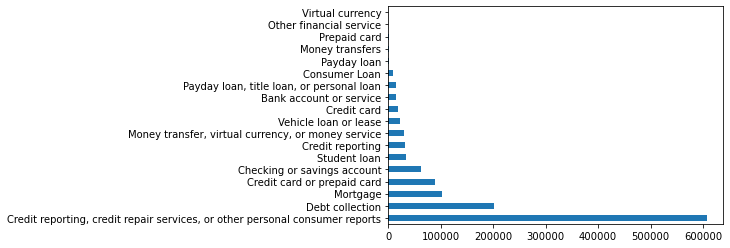

In [18]:
data.Product.value_counts().plot(kind='barh');

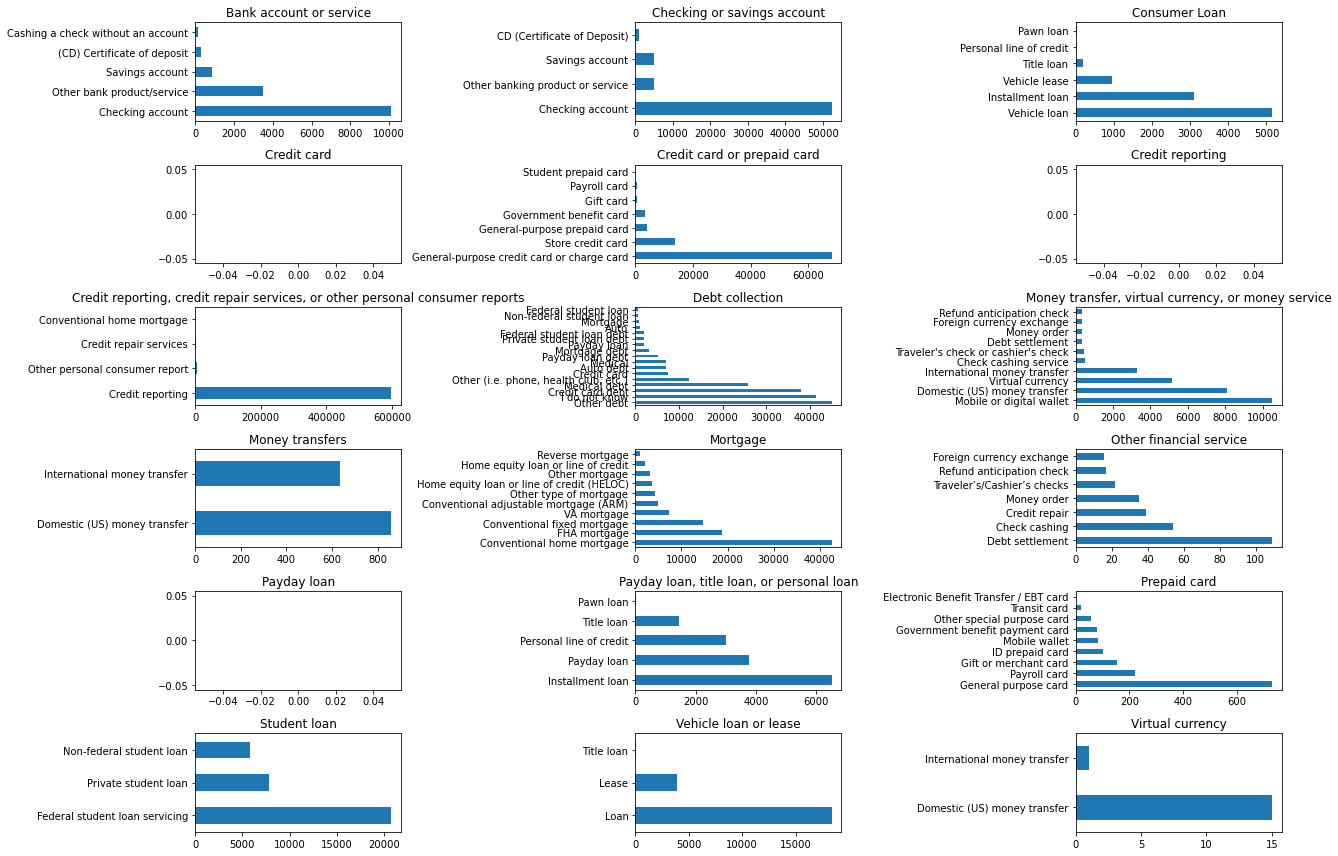

In [46]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(18, 12))

for n, product in enumerate(np.unique(data.Product)):
    i = n // 3
    j = n % 3
    try:
        data.loc[data.Product==product, 'Sub-product'].value_counts().plot(kind='barh',
                                                                           ax=ax[i][j])
        ax[i][j].set(title=f'{product}')
    except:
        ax[i][j].set(title=f'{product}')
        
fig.tight_layout();

The categories: "Credit card", "Credit reporting" and "Payday loan" have no sub-categories.

Were I truly working for a company that had gathered this data, this would be a great time to check documentation about the data and / or reach out to those who aggregate or enter the data to see if "Credit card", "Credit reporting" and "Payday loan" are truly different from the subproducts of the same name.

Because I don't have access to the people and documentation to figure this out, I am assuming the following:

"Credit reporting" and "Payday loan" are no different from the sub-products of the same name $\rightarrow$ change product and sub-product labels for these records

"Credit card" cannot be assumed to be a particular type of credit card $\rightarrow$ change product and sub-product labels for these records, but create a new sub-product "unknown credit card"

In [65]:
data.loc[data.Product=='Credit reporting','Sub-product'] =\
data.loc[data.Product=='Credit reporting','Sub-product'].fillna('Credit reporting')

data.loc[data.Product=='Credit reporting','Product'] =\
data.loc[data.Product=='Credit reporting','Product'].replace(
    to_replace='Credit reporting',
    value='Credit reporting, credit repair services, or other personal consumer reports'
)

In [73]:
data.loc[data.Product=='Payday loan','Sub-product'] =\
data.loc[data.Product=='Payday loan','Sub-product'].fillna('Payday loan')

data.loc[data.Product=='Payday loan','Product'] =\
data.loc[data.Product=='Payday loan','Product'].replace(
    to_replace='Payday loan',
    value='Payday loan, title loan, or personal loan'
)

In [81]:
data.loc[data.Product=='Credit card', 'Sub-product'] =\
data.loc[data.Product=='Credit card','Sub-product'].fillna('Unknown credit card')

data.loc[data.Product=='Credit card', 'Product'] = \
data.loc[data.Product=='Credit card', 'Product'].replace(
to_replace='Credit card',
value='Credit card or prepaid card')

In [90]:
data.Issue.value_counts(normalize=True)*100

Incorrect information on your report                                                22.662268
Problem with a credit reporting company's investigation into an existing problem    14.981273
Improper use of your report                                                         10.265128
Attempts to collect debt not owed                                                    6.216682
Managing an account                                                                  2.803728
                                                                                      ...    
Property was damaged or destroyed property                                           0.000402
Problem with an overdraft                                                            0.000321
Lender sold the property                                                             0.000241
Lender damaged or destroyed vehicle                                                  0.000161
Lender damaged or destroyed property                        

Checking or savings account:
   Managing an account
   Closing an account
   Problem with a lender or other company charging your account
   Opening an account
   Problem caused by your funds being low
   Incorrect information on your report
   Problem with a credit reporting company's investigation into an existing problem
   Problem with fraud alerts or security freezes
   Improper use of your report
   Credit monitoring or identity theft protection services
   Unable to get your credit report or credit score
   Getting a line of credit


Consumer Loan:
   Managing the loan or lease
   Problems when you are unable to pay
   Taking out the loan or lease
   Shopping for a loan or lease
   Charged fees or interest I didn't expect
   Can't contact lender
   Lender repossessed or sold the vehicle
   Payment to acct not credited
   Account terms and changes
   Managing the line of credit
   Applied for loan/did not receive money
   Shopping for a line of credit
   Received a loan I didn't 

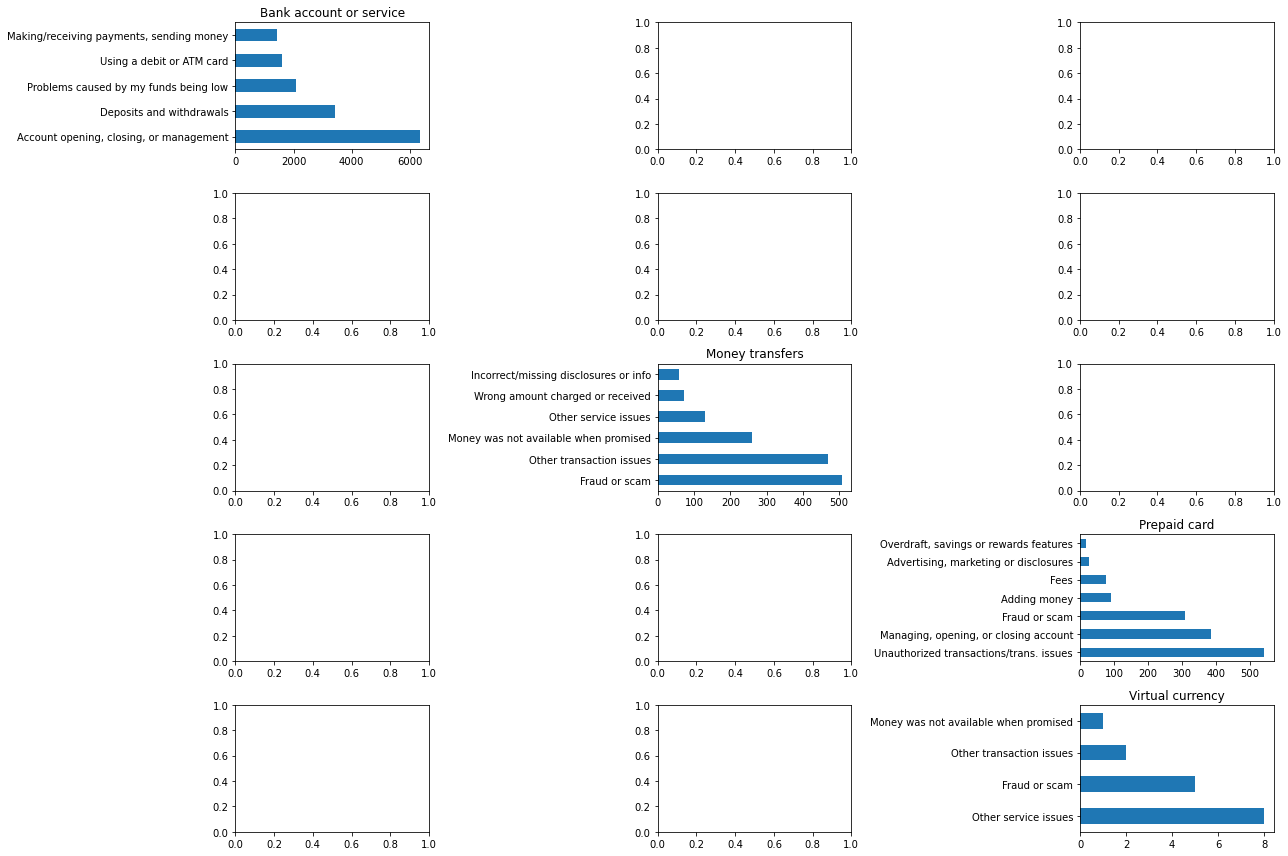

In [92]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(18, 12))

for n, product in enumerate(np.unique(data.Product)):
    i = n // 3
    j = n % 3
    if len(data.loc[data.Product==product, 'Issue'].value_counts()) < 8:
        try:
            data.loc[data.Product==product, 'Issue'].value_counts().plot(kind='barh',
                                                                               ax=ax[i][j])
            ax[i][j].set(title=f'{product}')
        except:
            ax[i][j].set(title=f'{product}')
    else:
        print(f'{product}:')
        for issue in list(data.loc[data.Product==product, 'Issue'].value_counts().index):
            print(f'   {issue}')
        print('\n')
        
fig.tight_layout();

In [94]:
data.Company.value_counts(normalize=True)*100

EQUIFAX, INC.                             15.678209
TRANSUNION INTERMEDIATE HOLDINGS, INC.    13.866433
Experian Information Solutions Inc.       13.397043
WELLS FARGO & COMPANY                      2.624454
BANK OF AMERICA, NATIONAL ASSOCIATION      2.563411
                                            ...    
Empire Mortgage (NV)                       0.000080
K2 Lending, Inc.                           0.000080
TitleMax LLC                               0.000080
Direct Home Loans, LLC                     0.000080
Financial Warranty LLC                     0.000080
Name: Company, Length: 5594, dtype: float64

----

In [4]:
subset = pd.DataFrame({'Complaint': data.loc[:,'Consumer complaint narrative'].values,
                       'Company': data.loc[:, 'Company'].values,
                       'Product': data.loc[:, 'Product'].values},
                      index = data.index
                     )

In [5]:
subset.head()

,Complaint,Company,Product
84,I am a victim of identity theft. XXXX XXXX XXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
180,XXXX 2022 went just like any other XXXX of the...,Netspend Corporation,Checking or savings account
369,In XXXX I fell behind on my mortgage payments ...,WELLS FARGO & COMPANY,Mortgage
549,I immigrated to the United States in XX/XX/XXX...,"EQUIFAX, INC.",Credit reporting
583,ATTN Fraud Department : Remove fraudulent acco...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."


In [6]:
# set a seed for reproducibility
seed = 839

In [8]:
# get 100,000 records to build a proof-of-concept model
sample = subset.sample(100000, random_state=seed).copy()

In [10]:
# import a word tokenizer
from nltk.tokenize import word_tokenize

sample['tokenized_complaint'] = sample['Complaint'].map(lambda x: word_tokenize(x))

In [11]:
sample.head()

,Complaint,Company,Product,tokenized_complaint
3347590,XXXX XXXX XXXX XXXX : XXXX. XXXXXXXX XXXX XXXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...","[XXXX, XXXX, XXXX, XXXX, :, XXXX, ., XXXXXXXX,..."
3273724,I have written you twice. Chase finds ways out...,JPMORGAN CHASE & CO.,Mortgage,"[I, have, written, you, twice, ., Chase, finds..."
543587,"I contacted Amex, who placed the inquiry, and ...",AMERICAN EXPRESS COMPANY,"Credit reporting, credit repair services, or o...","[I, contacted, Amex, ,, who, placed, the, inqu..."
1039197,"In XXXX of 2018, I started getting calls from ...","CREDIT BUREAU OF NAPA COUNTY, INC.",Debt collection,"[In, XXXX, of, 2018, ,, I, started, getting, c..."
1935540,On ( XX/XX/2022 ) I sent a letter regarding in...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...","[On, (, XX/XX/2022, ), I, sent, a, letter, reg..."


Test out strategies for preparing the complaint text for a classification model using one complaint.

In [13]:
test_complaint = sample.loc[3347590, 'Complaint']
test_complaint

'XXXX XXXX XXXX XXXX : XXXX. XXXXXXXX XXXX XXXXXXXX XXXX XXXX XXXX XXXX XXXX XXXX, XXXX XXXX XXXX XXXX, IN XXXX XXXXXXXX XXXX XXXX \nXXXX : XXXX. XXXX XXXX XXXX XXXX XXXX \nXXXX XXXX XXXX # XXXX XXXX, FL XXXX These companies are reporting hard inquiries on my equifax credit report that I do not recognize. I do not have any open accounts with these companies.'

Remove punctuation, change all words to lowercase and remove stopwords.

In [27]:
from nltk.corpus import stopwords
import string

stopwords_list = stopwords.words('english')
stopwords_list.extend(string.punctuation)

tokens = [w.lower() for w in word_tokenize(test_complaint) if w.lower() not in stopwords_list]

Remove Xs representing redacted material.

In [28]:
import re

pattern = 'x+x+'
p = re.compile(pattern)
results = p.findall(' '.join(tokens))

In [29]:
for redacted in results:
    tokens.remove(redacted)
    
tokens

['fl',
 'companies',
 'reporting',
 'hard',
 'inquiries',
 'equifax',
 'credit',
 'report',
 'recognize',
 'open',
 'accounts',
 'companies']

Lemmatize tokens. (Tag with part of speech first, to ensure verbs are correctly lemmatized.)

In [47]:
# helper function
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [59]:
import nltk

nltk.download('wordnet')
nltk.download('tagsets')

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

lemmas = [lemmatizer.lemmatize(*t) for t in\
          [(pair[0], get_wordnet_pos(pair[1])) for pair in nltk.pos_tag(tokens)]
         ]
lemmas

[nltk_data] Downloading package tagsets to /Users/user/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


['fl',
 'company',
 'report',
 'hard',
 'inquiry',
 'equifax',
 'credit',
 'report',
 'recognize',
 'open',
 'account',
 'company']

Consider bigrams to get a little more context around each token. Score with pointwise mutual information score.

In [72]:
raw_bigrams = list(nltk.bigrams(lemmas))

In [63]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
bigrams = nltk.BigramCollocationFinder.from_words(lemmas)
scored_bigrams = bigrams.score_ngrams(bigram_measures.pmi)
scored_bigrams

[(('equifax', 'credit'), 3.5849625007211565),
 (('hard', 'inquiry'), 3.5849625007211565),
 (('inquiry', 'equifax'), 3.5849625007211565),
 (('open', 'account'), 3.5849625007211565),
 (('recognize', 'open'), 3.5849625007211565),
 (('account', 'company'), 2.5849625007211565),
 (('credit', 'report'), 2.5849625007211565),
 (('fl', 'company'), 2.5849625007211565),
 (('report', 'hard'), 2.5849625007211565),
 (('report', 'recognize'), 2.5849625007211565),
 (('company', 'report'), 1.5849625007211565)]

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()

transformed_lemmas = vec.fit_transform([' '.join(lemmas)])

To test the results obtained by the TfidfVectorizer from sklearn, I printed out the transformed matrix and compared it to the list and "value counts" of the generated lemmas.

Most words appear once and have a tf-idf of 0.25, whereas the two which appear twice have a tf-idf of 0.5.

The tf-idf of a term is calculated by: (term frequency) * (reciprocal of document frequency)

According to [the sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer), for the words which appear once: tf = 1 / 12 (because there are 12 terms in the document), and idf = (natural log of 1 / 1) + 1, because each one appears in 1 document out of all 1 documents, and plus 1 because of smoothing. Therefore, the tf-idf of each word which appears once is: 1/12 * 1 - which doesn't align with the value I saw! Yikes.

For a word which appears twice, I would expect 2/12 * ln(1/1)+1 = 1/6.

Could the tf-idf be "normalized" somehow? Though I'm not getting 1/12 and 1/6 with the sklearn function, the sklearn function values have the same ratios (the words which appeared twice have a 2:1 ratio with those that appeared once.)

In [91]:
print(lemmas)

['fl', 'company', 'report', 'hard', 'inquiry', 'equifax', 'credit', 'report', 'recognize', 'open', 'account', 'company']


In [93]:
pd.Series(lemmas).value_counts()

company      2
report       2
fl           1
recognize    1
equifax      1
hard         1
inquiry      1
open         1
account      1
credit       1
dtype: int64

In [88]:
transformed_lemmas.todense()

matrix([[0.25, 0.5 , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5 ]])

It is hard to tell if tf-idf is working properly when there is only one complaint.

Next, let's apply our preprocessing steps systematically to a subsample of 5 complaints, fit a Tfidf vectorizer, and check the results of the vectorization.

Then, we'll proceed to do a train/test/split and fit a baseline classifier to all of the training data (the preprocessed complaints and the bigrams / pmi scores we found.)

I expect to need to tune the min/max threshold of frequently occurring words and bigrams to improve the classifier's performance, and possibly the preprocessing techniques used.

In [447]:
subsample = sample.sample(5)

In [433]:
subsample['tokens'] = subsample.Complaint.map(
    lambda x: [w.lower() for w in word_tokenize(x) if w.lower() not in stopwords_list]
)

In [448]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

stopwords_list = stopwords.words('english')
stopwords_list.extend(string.punctuation)

def get_tokens(complaint):
    '''Takes in a string and returns a list of lowercase tokens without punctuation or
    common English stopwords.'''
    return [w.lower() for w in word_tokenize(complaint) if w.lower() not in stopwords_list]

In [434]:
subsample.Complaint.map(get_tokens) == subsample['tokens']

2126334    True
1264438    True
382467     True
1242711    True
1172567    True
dtype: bool

In [450]:
subsample['tokens'] = subsample.Complaint.map(get_tokens)

In [476]:
clean_data = remove_redactions(subsample)

In [479]:
clean_data

,clean_tokens,Complaint,Company,Product,tokenized_complaint,tokens
2203080,"[recently, locked, online, account, pay, bill,...",Recently I was locked out of my online account...,CAPITAL ONE FINANCIAL CORPORATION,Credit card or prepaid card,"[Recently, I, was, locked, out, of, my, online...","[recently, locked, online, account, pay, bill,..."
396597,"[name, third, party, involved, attached, id, d...",My name is XXXX XXXX XXXX There is no third pa...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...","[My, name, is, XXXX, XXXX, XXXX, There, is, no...","[name, xxxx, xxxx, xxxx, third, party, involve..."
1778976,"[accordance, fair, credit, reporting, act, lis...",In accordance with the Fair Credit Reporting a...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","Credit reporting, credit repair services, or o...","[In, accordance, with, the, Fair, Credit, Repo...","[accordance, fair, credit, reporting, act, lis..."
1584788,"[accordance, fair, credit, reporting, act, fai...",In accordance with the Fair Credit Reporting A...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...","[In, accordance, with, the, Fair, Credit, Repo...","[accordance, fair, credit, reporting, act, fai..."
1670028,"[hello, thank, assistance, last, collection, a...",Hello and thank you for your assistance. \nLas...,FMS Inc.,"Credit reporting, credit repair services, or o...","[Hello, and, thank, you, for, your, assistance...","[hello, thank, assistance, last, xxxx, collect..."


----

Before I lemmatize my tokens, I want to clean out all of the redacted items.

To do that, I created a temporary column 'regex' which searches the contents of the 'tokens' column for a regular expression that should match redacted items.

Then I exploded the dataframe by tokens. I created a separate dataframe with an exploded version of the regex column.

For each index, I iterated over each token, and checked whether the token matched any of the values in the exploded regex column; if not, then I kept that token.

I created a new dataframe with these lists of tokens which are not redacted and the column name 'clean_tokens', then concatenated it with the original sample by index in a new dataframe called "clean_data".

In [471]:
def remove_redactions(sample):
    # create and compile regular expression pattern
    pattern = '\S*x+x+\S*'
    p = re.compile(pattern)
    
    # find pattern matches for each list of tokens
    regex_series = sample.tokens.map(lambda x: p.findall(' '.join(x)))
    
    # explode dataframe to access each token individually
    tokens_by_index = sample.explode('tokens').tokens
    
    # store info for cleaned tokens for each index
    indices = list(sample.index)
    cleaned_tokens = []

    # iterate over all indices
    for index in indices:
        # create a list of tokens to keep
        tokens = []
        # for each token corresponding to that index
        for token in tokens_by_index[index]:
            keep = 0 # assume that we won't keep this token
            # iterate over all redacted items from the list of tokens (skip if list is empty)
            if regex_series[index]:
                for redacted in regex_series[index]:
                    if token == redacted:
                        keep=0 # don't keep it if it's a "redacted" token
                        break
                    else: # keep checking if it matches other redacted patterns
                        keep=1
                        continue
                if keep==1:
                    tokens.append(token)
            else: # if there are no redacted expressions, keep all tokens
                tokens = list(tokens_by_index[index].values)
                
        # append the list of tokens for this index to the list of cleaned_tokens            
        cleaned_tokens.append(tokens)
        
    # concatenate new results with old
    clean_data = pd.concat([pd.DataFrame({'clean_tokens': cleaned_tokens}, index=indices),
                            sample],
                       axis=1)
    
    # return clean data
    return clean_data

In [308]:
# find and remove redacted items
pattern2 = '\S*x+x+\S*'
p2 = re.compile(pattern2)
# p2.findall('10/52xxxxiii hello') #test
subsample['regex'] = subsample.tokens.map(lambda x: p8.findall(' '.join(x)))

In [376]:
# explode by tokens & regex separately
d2 = subsample.explode('tokens')
d3 = subsample.explode('regex').regex

# store info for cleaned tokens for each index
indices = list(subsample.index)
cleaned_tokens = []

# iterate over all indices
for index in indices:
    # create a list of tokens to keep
    tokens = []
    # for each token corresponding to that index
    for token in d6.loc[index, 'tokens']:
        keep = 0 # assume that we won't keep this token
        # iterate over all redacted items from the list of tokens (skip if list is empty)
        try:
            for redacted in list(d7[index]):
                if token == redacted:
                    keep=0 # don't keep it if it's a "redacted" token
                    break
                else: # keep checking if it matches other redacted patterns
                    keep=1
                    continue
            if keep==1:
                tokens.append(token)
        except: # if there are no redacted expressions, keep all tokens
            tokens = list(d6.loc[index, 'tokens'].values)
            break
    cleaned_tokens.append(tokens)

In [377]:
pd.DataFrame({'clean_tokens': cleaned_tokens}, index=indices)

,clean_tokens
1743835,"[spent, 40, hours, last, 5, months, person, ph..."
2445671,"[got, un-authorized, charge, amount, 620.00, c..."
2205985,"[applied, making, homes, affordable, modificat..."
736258,"[identity, compromised, idea, could, done, pul..."
1304966,"[filing, complaint, towards, bsi, financial, s..."


In [378]:
clean_data = pd.concat([pd.DataFrame({'clean_tokens': cleaned_tokens}, index=indices),
                        subsample],
                       axis=1)

In [379]:
clean_data.drop(['regex', 'tokens_cleaned', 'tokens_joined', 'cleaned_tokens'], axis=1,
                inplace=True)

In [380]:
clean_data

,clean_tokens,Complaint,Company,Product,tokens
1743835,"[spent, 40, hours, last, 5, months, person, ph...",I have spent over 40 hours in last 5 months in...,JPMORGAN CHASE & CO.,"Money transfer, virtual currency, or money ser...","[spent, 40, hours, last, 5, months, person, ph..."
2445671,"[got, un-authorized, charge, amount, 620.00, c...",I got an un-authorized charge in the amount of...,"CITIBANK, N.A.",Credit card or prepaid card,"[got, un-authorized, charge, amount, 620.00, x..."
2205985,"[applied, making, homes, affordable, modificat...",In XXXX I applied for a Making Homes Affordabl...,Specialized Loan Servicing Holdings LLC,Mortgage,"[xxxx, applied, making, homes, affordable, mod..."
736258,"[identity, compromised, idea, could, done, pul...",My identity has been compromised. I have no id...,Experian Information Solutions Inc.,"Credit reporting, credit repair services, or o...","[identity, compromised, idea, could, done, pul..."
1304966,"[filing, complaint, towards, bsi, financial, s...",Filing this complaint towards BSI Financial Se...,"Servis One, Inc., Titusville, PA Branch",Mortgage,"[filing, complaint, towards, bsi, financial, s..."


Now I'll lemmatize the tokens.

In [489]:
import nltk

# download wordnet & tagsets if you haven't already
nltk.download('wordnet')
nltk.download('tagsets')

# import lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# helper function
# function needed for helper function =)
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    '''Convert POS tags generated by nltk.pos_tag to wordnet tags, for use with word net
    lemmatizer provided in the nltk.stem.wordnet package.'''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# apply lemmatizer to wordnet-tagged words to get lemmas
clean_data['lemmas'] = clean_data.clean_tokens.map(
lambda x: [lemmatizer.lemmatize(*t) for t in\
          [(pair[0], get_wordnet_pos(pair[1])) for pair in nltk.pos_tag(x)]
         ])

In [492]:
clean_data.head()

,clean_tokens,Complaint,Company,Product,tokenized_complaint,tokens,lemmas
2203080,"[recently, locked, online, account, pay, bill,...",Recently I was locked out of my online account...,CAPITAL ONE FINANCIAL CORPORATION,Credit card or prepaid card,"[Recently, I, was, locked, out, of, my, online...","[recently, locked, online, account, pay, bill,...","[recently, lock, online, account, pay, bill, c..."
396597,"[name, third, party, involved, attached, id, d...",My name is XXXX XXXX XXXX There is no third pa...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...","[My, name, is, XXXX, XXXX, XXXX, There, is, no...","[name, xxxx, xxxx, xxxx, third, party, involve...","[name, third, party, involve, attached, id, do..."
1778976,"[accordance, fair, credit, reporting, act, lis...",In accordance with the Fair Credit Reporting a...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","Credit reporting, credit repair services, or o...","[In, accordance, with, the, Fair, Credit, Repo...","[accordance, fair, credit, reporting, act, lis...","[accordance, fair, credit, reporting, act, lis..."
1584788,"[accordance, fair, credit, reporting, act, fai...",In accordance with the Fair Credit Reporting A...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o...","[In, accordance, with, the, Fair, Credit, Repo...","[accordance, fair, credit, reporting, act, fai...","[accordance, fair, credit, reporting, act, fai..."
1670028,"[hello, thank, assistance, last, collection, a...",Hello and thank you for your assistance. \nLas...,FMS Inc.,"Credit reporting, credit repair services, or o...","[Hello, and, thank, you, for, your, assistance...","[hello, thank, assistance, last, xxxx, collect...","[hello, thank, assistance, last, collection, a..."


In [518]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_df=0.5)

vectorized_words = pd.DataFrame(
    tfidf_vec.fit_transform(clean_data['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec.vocabulary_.keys()),
    index=clean_data.index)

I performed a couple of checks to ensure that the vectorizer is working with my data as I intended (deleted for neatness.)

Let's use Naive Bayes for a baseline classifier.

In [525]:
from sklearn.naive_bayes import MultinomialNB

baseline = MultinomialNB()

In [526]:
baseline.fit(vectorized_words, subsample.Product)

MultinomialNB()

In [527]:
baseline.predict(vectorized_words)

array(['Credit reporting, credit repair services, or other personal consumer reports',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit reporting, credit repair services, or other personal consumer reports'],
      dtype='<U76')

----

With initial checks out of the way, let's split our data into train, test and validation sets and fit a baseline model to the entire training set.

In [532]:
sample.head()

,Complaint,Company,Product
3347590,XXXX XXXX XXXX XXXX : XXXX. XXXXXXXX XXXX XXXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
3273724,I have written you twice. Chase finds ways out...,JPMORGAN CHASE & CO.,Mortgage
543587,"I contacted Amex, who placed the inquiry, and ...",AMERICAN EXPRESS COMPANY,"Credit reporting, credit repair services, or o..."
1039197,"In XXXX of 2018, I started getting calls from ...","CREDIT BUREAU OF NAPA COUNTY, INC.",Debt collection
1935540,On ( XX/XX/2022 ) I sent a letter regarding in...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."


In [542]:
from sklearn.model_selection import train_test_split

X = sample.drop(['Product'], axis=1).copy()
y = sample.Product.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [543]:
# split training data into training and validation data

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=seed)

In [544]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(60000, 2)
(20000, 2)
(20000, 2)


In [545]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

stopwords_list = stopwords.words('english')
stopwords_list.extend(string.punctuation)

def get_tokens(complaint):
    '''Takes in a string and returns a list of lowercase tokens without punctuation or
    common English stopwords.'''
    return [w.lower() for w in word_tokenize(complaint) if w.lower() not in stopwords_list]

In [547]:
X_train.head()

,Complaint,Company
364212,"This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC."
2207116,I am disputing a couple of inaccurate items on...,"EQUIFAX, INC."
1015564,I have contacted this company on several occas...,Penn Credit Corporation
1647648,My mother was contacted by an XXXX representat...,BTH Management
2082209,On XXXX XXXX I sent a letter regarding an accu...,"EQUIFAX, INC."


In [549]:
X_train['tokens'] = X_train.Complaint.map(get_tokens)

In [550]:
X_train.head()

,Complaint,Company,tokens
364212,"This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC.","[xxxx, xxxx, submitting, cfpb, complaint, info..."
2207116,I am disputing a couple of inaccurate items on...,"EQUIFAX, INC.","[disputing, couple, inaccurate, items, credit,..."
1015564,I have contacted this company on several occas...,Penn Credit Corporation,"[contacted, company, several, occassions, spok..."
1647648,My mother was contacted by an XXXX representat...,BTH Management,"[mother, contacted, xxxx, representative, xx/x..."
2082209,On XXXX XXXX I sent a letter regarding an accu...,"EQUIFAX, INC.","[xxxx, xxxx, sent, letter, regarding, accurate..."


In [576]:
import re

def remove_redactions(sample):
    # create and compile regular expression pattern
    pattern = '\S*x+x+\S*'
    p = re.compile(pattern)
    
    # find pattern matches for each list of tokens
    regex_series = sample.tokens.map(lambda x: p.findall(' '.join(x)))
    
    # explode dataframe to access each token individually
    tokens_by_index = sample.tokens.copy()
    
    # store info for cleaned tokens for each index
    indices = list(sample.index)
    cleaned_tokens = []

    # iterate over all indices
    for index in indices:
        # create a list of tokens to keep
        tokens = []
        # for each token corresponding to that index
        for token in tokens_by_index[index]:
            keep = 0 # assume that we won't keep this token
            # iterate over all redacted items from the list of tokens (skip if list is empty)
            if regex_series[index]:
                for redacted in regex_series[index]:
                    if token == redacted:
                        keep=0 # don't keep it if it's a "redacted" token
                        break
                    else: # keep checking if it matches other redacted patterns
                        keep=1
                        continue
                if keep==1:
                    tokens.append(token)
            else: # if there are no redacted expressions, keep all tokens
                tokens = tokens_by_index[index]
                
        # append the list of tokens for this index to the list of cleaned_tokens            
        cleaned_tokens.append(tokens)
        
    # concatenate new results with old
    clean_data = pd.concat([pd.DataFrame({'clean_tokens': cleaned_tokens}, index=indices),
                            sample],
                       axis=1)
    
    # return clean data
    return clean_data

In [577]:
clean_data = remove_redactions(X_train)

In [578]:
clean_data.head()

,clean_tokens,Complaint,Company,tokens
364212,"[submitting, cfpb, complaint, inform, third, p...","This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC.","[xxxx, xxxx, submitting, cfpb, complaint, info..."
2207116,"[disputing, couple, inaccurate, items, credit,...",I am disputing a couple of inaccurate items on...,"EQUIFAX, INC.","[disputing, couple, inaccurate, items, credit,..."
1015564,"[contacted, company, several, occassions, spok...",I have contacted this company on several occas...,Penn Credit Corporation,"[contacted, company, several, occassions, spok..."
1647648,"[mother, contacted, representative, shared, pr...",My mother was contacted by an XXXX representat...,BTH Management,"[mother, contacted, xxxx, representative, xx/x..."
2082209,"[sent, letter, regarding, accurate, unknown, t...",On XXXX XXXX I sent a letter regarding an accu...,"EQUIFAX, INC.","[xxxx, xxxx, sent, letter, regarding, accurate..."


In [579]:
# download wordnet & tagsets if you haven't already
import nltk
nltk.download('wordnet')
nltk.download('tagsets')

# helper function to get wordnet pos_tags from nltk pos_tags
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    '''Convert POS tags generated by nltk.pos_tag to wordnet tags, for use with word net
    lemmatizer provided in the nltk.stem.wordnet package.'''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/user/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [580]:
# import lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# also import nltk to get pos_tags below
import nltk

# apply lemmatizer to wordnet-tagged words to get lemmas
clean_data['lemmas'] = clean_data.clean_tokens.map(
lambda x: [lemmatizer.lemmatize(*t) for t in\
          [(pair[0], get_wordnet_pos(pair[1])) for pair in nltk.pos_tag(x)]
         ])

In [581]:
clean_data.head()

,clean_tokens,Complaint,Company,tokens,lemmas
364212,"[submitting, cfpb, complaint, inform, third, p...","This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC.","[xxxx, xxxx, submitting, cfpb, complaint, info...","[submit, cfpb, complaint, inform, third, party..."
2207116,"[disputing, couple, inaccurate, items, credit,...",I am disputing a couple of inaccurate items on...,"EQUIFAX, INC.","[disputing, couple, inaccurate, items, credit,...","[dispute, couple, inaccurate, item, credit, re..."
1015564,"[contacted, company, several, occassions, spok...",I have contacted this company on several occas...,Penn Credit Corporation,"[contacted, company, several, occassions, spok...","[contact, company, several, occassions, speak,..."
1647648,"[mother, contacted, representative, shared, pr...",My mother was contacted by an XXXX representat...,BTH Management,"[mother, contacted, xxxx, representative, xx/x...","[mother, contact, representative, share, priva..."
2082209,"[sent, letter, regarding, accurate, unknown, t...",On XXXX XXXX I sent a letter regarding an accu...,"EQUIFAX, INC.","[xxxx, xxxx, sent, letter, regarding, accurate...","[sent, letter, regard, accurate, unknown, thin..."


In [582]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(max_df=0.5)

vectorized_words = pd.DataFrame(
    tfidf_vec.fit_transform(clean_data['lemmas'].map(lambda x: ' '.join(x))).todense(),
    columns=list(tfidf_vec.vocabulary_.keys()),
    index=clean_data.index)

In [583]:
vectorized_words.head()

,submit,cfpb,complaint,inform,third,party,involved,process,send,letter,...,verififcation,clarifiy,affliate,refuting,penatgon,attatching,conatact,cherrington,candy,acquantained
364212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2207116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1015564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1647648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2082209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [584]:
from sklearn.naive_bayes import MultinomialNB

baseline = MultinomialNB()

baseline.fit(vectorized_words, y_train)

baseline.score(vectorized_words, y_train)

0.6732